In [1]:
import pandas as pd
import numpy as np 

import catboost as cb

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('/kaggle/input/case-ih-time-series-data/data.csv')

In [3]:
df.head()

,date,work,income
0,"Thursday, September 30, 2021",2,2100
1,"Sunday, October 03, 2021",1,3600
2,"Monday, October 04, 2021",1,4000
3,"Tuesday, October 05, 2021",1,7900
4,"Wednesday, October 06, 2021",1,7500


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
data = pd.DataFrame(df.income.copy())

In [6]:
data.columns = ["y"]

In [7]:
data.head()

,y
0,2100
1,3600
2,4000
3,7900
4,7500


In [8]:
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [9]:
data.head()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
0,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
x = data.dropna().drop(['y'], axis=1)

y = data.dropna().y

In [11]:
x.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
24,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0,7900.0,4000.0,3600.0,2100.0
25,2100.0,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0,7900.0,4000.0,3600.0
26,6400.0,2100.0,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0,7900.0,4000.0
27,2400.0,6400.0,2100.0,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0,7900.0
28,2000.0,2400.0,6400.0,2100.0,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0


In [12]:
tscv = TimeSeriesSplit(n_splits=5)

In [13]:
def timeseries_train_test_split(x, y, test_size):
    
    test_index = int(len(x)*(1-test_size))
    
    x_train = x.iloc[:test_index]
    y_train = y.iloc[:test_index]
    
    x_test = x.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return x_train, x_test, y_train, y_test

In [14]:
x_train, x_test, y_train, y_test = timeseries_train_test_split(x, y, test_size=0.3)

In [15]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(117, 19)
(51, 19)
(117,)
(51,)


In [16]:
train_dataset = cb.Pool(x_train, y_train) 
test_dataset = cb.Pool(x_test, y_test)

In [17]:
cb_model = cb.CatBoostRegressor(loss_function='RMSE')

In [18]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [19]:
cb_model.grid_search(grid, train_dataset)

0:	learn: 8648.5519038	test: 9174.6252988	best: 9174.6252988 (0)	total: 58.3ms	remaining: 5.77s
1:	learn: 8438.6519009	test: 8961.0761254	best: 8961.0761254 (1)	total: 59ms	remaining: 2.89s
2:	learn: 8235.9667546	test: 8744.4091258	best: 8744.4091258 (2)	total: 59.4ms	remaining: 1.92s
3:	learn: 8038.8405351	test: 8543.4499490	best: 8543.4499490 (3)	total: 59.9ms	remaining: 1.44s
4:	learn: 7847.0456547	test: 8344.2034626	best: 8344.2034626 (4)	total: 60.2ms	remaining: 1.14s
5:	learn: 7665.2849234	test: 8157.7392873	best: 8157.7392873 (5)	total: 60.7ms	remaining: 950ms
6:	learn: 7489.9986298	test: 7968.2560160	best: 7968.2560160 (6)	total: 61ms	remaining: 811ms
7:	learn: 7321.1576929	test: 7791.2787622	best: 7791.2787622 (7)	total: 61.4ms	remaining: 706ms
8:	learn: 7159.0550771	test: 7619.4093672	best: 7619.4093672 (8)	total: 61.6ms	remaining: 623ms
9:	learn: 7003.1038885	test: 7451.4539666	best: 7451.4539666 (9)	total: 61.9ms	remaining: 557ms
10:	learn: 6851.4278937	test: 7281.8031527	b

{'params': {'depth': 2,
  'l2_leaf_reg': 3,
  'iterations': 100,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [20]:
pred = cb_model.predict(x_test)

In [21]:
rmse = (np.sqrt(mean_squared_error(y_test, pred)))

print("Testing performance")
print("RMSE: {:.2f}".format(rmse))

Testing performance
RMSE: 3709.08


Text(0.5, 0, 'CatBoost Feature Importance')

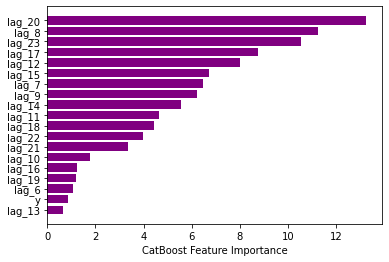

In [22]:
sorted_feature_importance = cb_model.feature_importances_.argsort()

plt.barh(data.columns[sorted_feature_importance], 
        cb_model.feature_importances_[sorted_feature_importance], 
        color='purple')

plt.xlabel("CatBoost Feature Importance")